In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [2]:
BASE_RESULTS_DIR = '/media/big-ssd/results-P3856'

In [3]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'

IDENTIFICATIONS_WITH_CS_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-18-05-00-25/identifications-pasef'.format(BASE_RESULTS_DIR)
IDENTIFICATIONS_WITH_CS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_WITH_CS_DIR, experiment_name, feature_detection_method)

In [4]:
IDENTIFICATIONS_WITH_CS_FILE

'/media/big-ssd/results-P3856/P3856-results-cs-true-fmdw-true-2021-05-18-05-00-25/identifications-pasef/exp-P3856-identifications-pasef-recalibrated.pkl'

In [5]:
MAXIMUM_Q_VALUE = 0.01

#### identifications with correction for saturation

In [6]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_WITH_CS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_cs_df = d['identifications_df']
identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

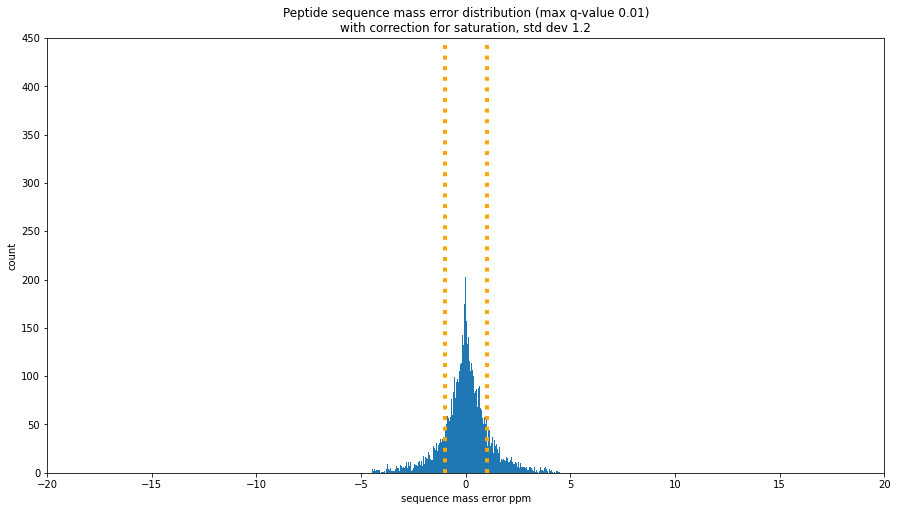

In [7]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nwith correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_with_cs_df.mass_accuracy_ppm.std(),1)))

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,450))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### identifications without correction for saturation

In [8]:
IDENTIFICATIONS_DIR = '{}/P3856-results-cs-false-fmdw-true-2021-05-18-08-01-44/identifications-pasef'.format(BASE_RESULTS_DIR)
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [9]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_without_cs_df = d['identifications_df']
identifications_without_cs_df = identifications_without_cs_df[(identifications_without_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

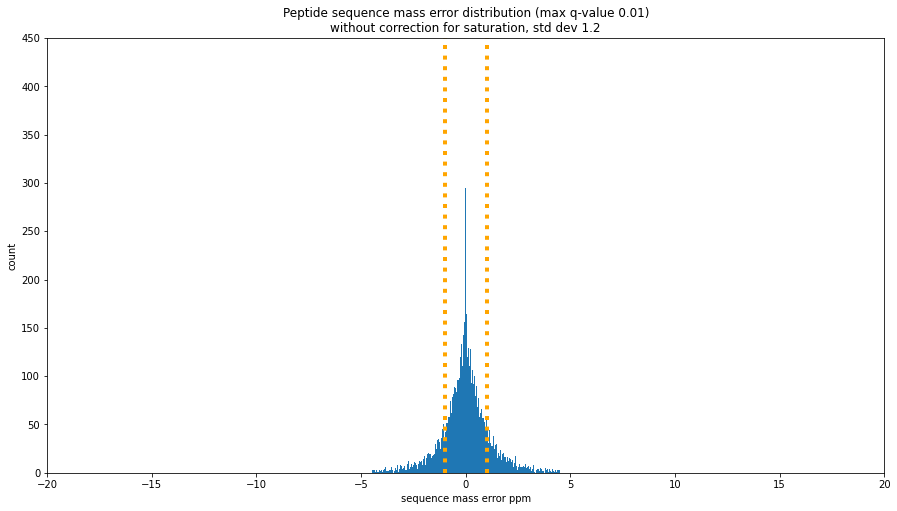

In [10]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nwithout correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_without_cs_df.mass_accuracy_ppm.std(),1)))

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,450))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### unique identifications found with and without saturation correction

In [12]:
affected_idents_df = identifications_with_cs_df[(identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted')]

In [13]:
sequences_l = []
for group_name,group_df in affected_idents_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    mass_accuracy_ppm_abs = abs(group_df.mass_accuracy_ppm).min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value, 'mass_accuracy_ppm':mass_accuracy_ppm, 'mass_accuracy_ppm_abs':mass_accuracy_ppm_abs})
sequences_with_cs_df = pd.DataFrame(sequences_l)

In [14]:
sequences_l = []
for group_name,group_df in identifications_without_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    mass_accuracy_ppm_abs = abs(group_df.mass_accuracy_ppm).min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value, 'mass_accuracy_ppm':mass_accuracy_ppm, 'mass_accuracy_ppm_abs':mass_accuracy_ppm_abs})
sequences_without_cs_df = pd.DataFrame(sequences_l)

In [15]:
combined_df = pd.merge(sequences_with_cs_df, sequences_without_cs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'], suffixes=['_with_cs','_without_cs'])


In [16]:
combined_df.sample(n=5)

,sequence,charge,score_with_cs,q_value_with_cs,mass_accuracy_ppm_with_cs,mass_accuracy_ppm_abs_with_cs,score_without_cs,q_value_without_cs,mass_accuracy_ppm_without_cs,mass_accuracy_ppm_abs_without_cs
198,LPGGELNPGEDEVEGLK,2,0.615439,0.000186,-0.006951,0.006951,0.610819,0.000197,0.401873,0.401873
348,WGDAGAEYVVESTGVFTTMEK,2,1.784862,0.000186,-0.035137,0.035137,1.753049,0.000197,-0.066486,0.066486
125,GVNLPGTDVDLPALSEK,2,1.070811,0.000186,-0.034968,0.034968,1.052402,0.000197,-0.432990,0.106790
44,DELHIVEAEAMNYEGSPIK,2,1.219095,0.000186,-0.120967,0.120967,1.204601,0.000197,0.523930,0.523930
252,QAVVNPENTLFATK,2,0.544723,0.000186,0.131362,0.131362,0.516328,0.000315,-0.409608,0.409608


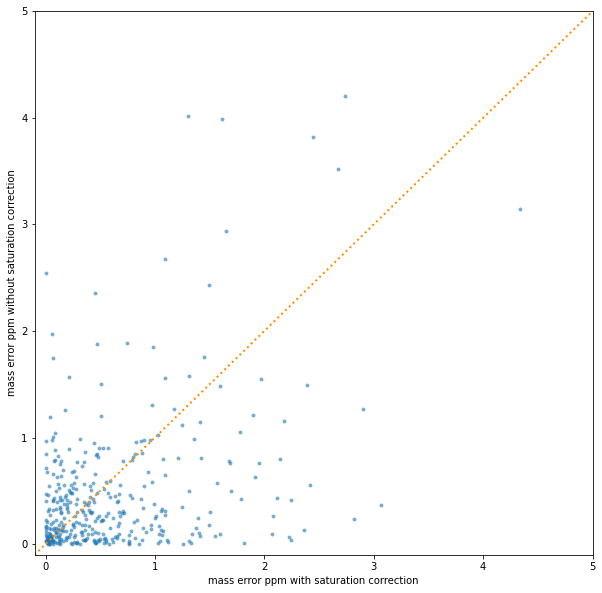

In [17]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(combined_df.mass_accuracy_ppm_abs_with_cs, combined_df.mass_accuracy_ppm_abs_without_cs, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-0.1,5.0))
plt.ylim((-0.1,5.0))

plt.xlabel('mass error ppm with saturation correction')
plt.ylabel('mass error ppm without saturation correction')

plt.show()

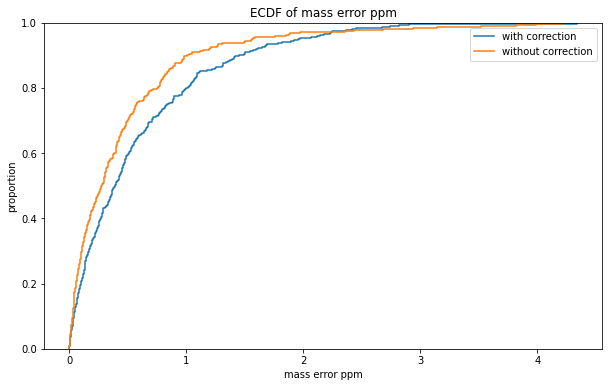

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 6))

title = 'ECDF of mass error ppm'
plt.title(title)

ax = sns.ecdfplot(data=combined_df, x="mass_accuracy_ppm_abs_with_cs", label='with correction')
_ = sns.ecdfplot(data=combined_df, x="mass_accuracy_ppm_abs_without_cs", label='without correction')
plt.legend(loc='best')
_ = ax.set(xlabel='mass error ppm', ylabel='proportion')

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


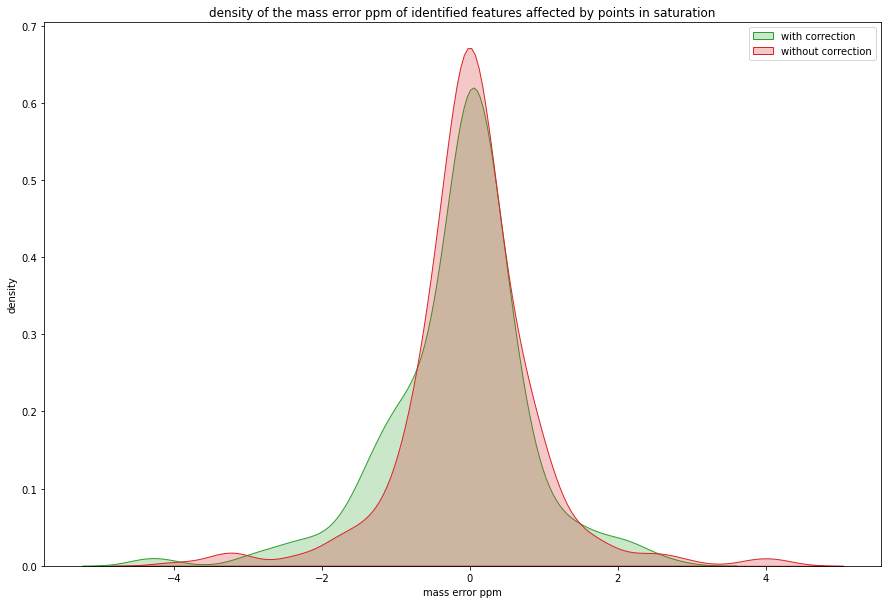

In [19]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'density of the mass error ppm of identified features affected by points in saturation'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(combined_df.mass_accuracy_ppm_with_cs, hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'with correction')
_ = sns.distplot(combined_df.mass_accuracy_ppm_without_cs, hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'without correction')

_ = ax.set(xlabel='mass error ppm', ylabel='density')
_ = ax.legend()

#### dynamic range comparison

In [20]:
s1 = identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=False).rename('counts', inplace=True)
s2 = round(identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=True)*100,1).rename('%', inplace=True)
pd.concat([s1, s2], axis=1)

,counts,%
monoisotopic_not_saturated,8328,95.1
monoisotopic_saturated_adjusted,422,4.8
no_nonsaturated_isotopes,3,0.0
could_not_calculate_phr,1,0.0


In [21]:
identifications_with_cs_df = identifications_with_cs_df.copy()
identifications_with_cs_df['intensity_log'] = np.log10(identifications_with_cs_df.feature_intensity)

identifications_without_cs_df = identifications_without_cs_df.copy()
identifications_without_cs_df['intensity_log'] = np.log10(identifications_without_cs_df.feature_intensity)

identifications_with_cs_df['method'] = 'corrected for saturation'
identifications_without_cs_df['method'] = 'not corrected for saturation'
idents_df = pd.concat([identifications_with_cs_df,identifications_without_cs_df], axis=0, sort=False)


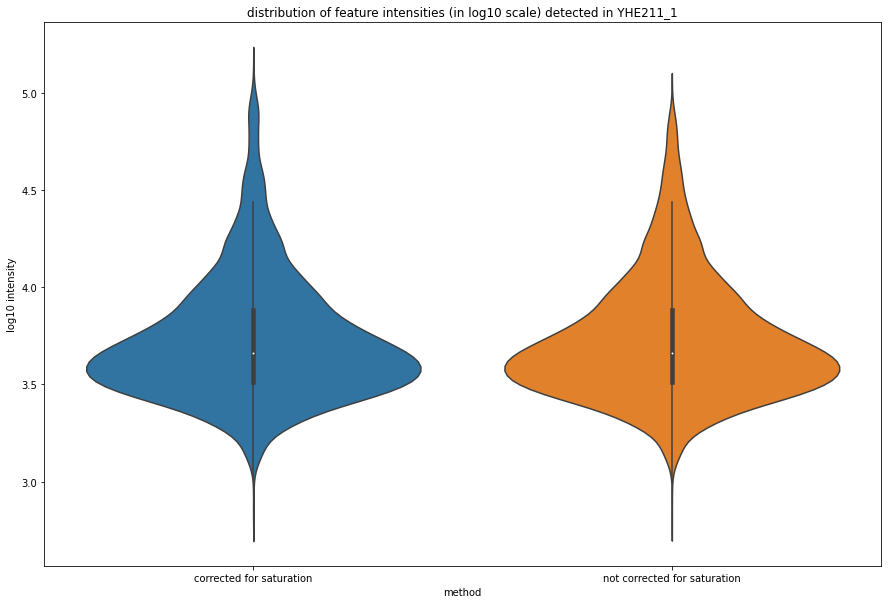

In [22]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=idents_df.method, y=idents_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

In [23]:
dynamic_range_with_cs = identifications_with_cs_df.intensity_log.max() - identifications_with_cs_df.intensity_log.min()
dynamic_range_without_cs = identifications_without_cs_df.intensity_log.max() - identifications_without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,2), round(dynamic_range_without_cs,2)))

orders of magnitude with cs: 2.34, without cs: 2.2


#### for those identifications with an adjusted intensity, what would the intensity range have been without correction?

In [24]:
adj_with_cs_df = identifications_with_cs_df[identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted']


In [25]:
adj_l = []
for row in adj_with_cs_df.itertuples():
    cs_intensity = row.intensity_with_saturation_correction if (row.intensity_with_saturation_correction > row.intensity_without_saturation_correction) else row.intensity_without_saturation_correction
    adj_l.append({'feature_intensity':cs_intensity, 'method':'corrected'})
    adj_l.append({'feature_intensity':row.intensity_without_saturation_correction, 'method':'not corrected'})
adj_df = pd.DataFrame(adj_l)
adj_df['intensity_log'] = np.log10(adj_df.feature_intensity)

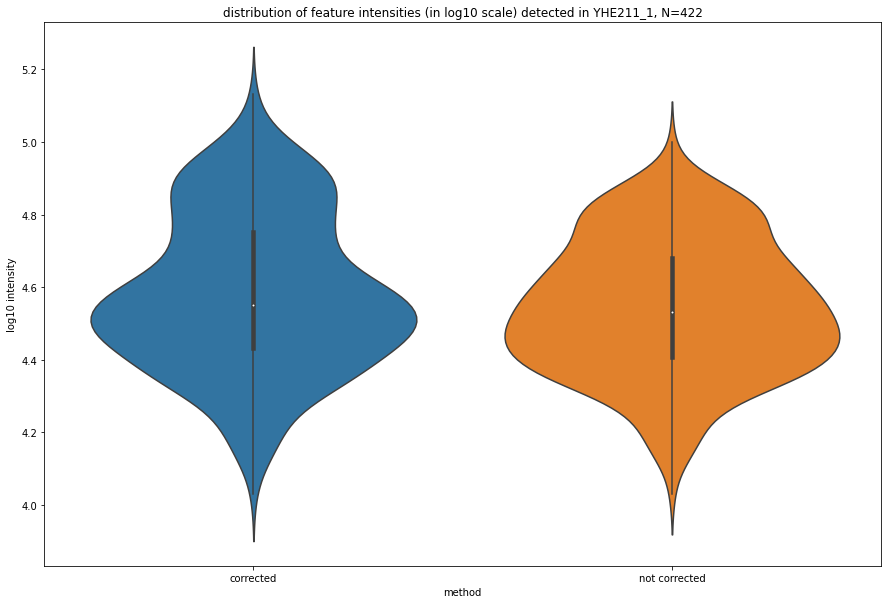

In [26]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=adj_df.method, y=adj_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1, N={}'.format(len(adj_with_cs_df)))

In [27]:
with_cs_df = adj_df[(adj_df.method == 'corrected')]
without_cs_df = adj_df[(adj_df.method == 'not corrected')]

dynamic_range_with_cs = with_cs_df.intensity_log.max() - with_cs_df.intensity_log.min()
dynamic_range_without_cs = without_cs_df.intensity_log.max() - without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,2), round(dynamic_range_without_cs,2)))

orders of magnitude with cs: 1.1, without cs: 0.97
